In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.metrics import Recall, Precision
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from keras.applications import ResNet101V2  
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras import layers
import multiprocessing

In [2]:
# Define the path to the data directory
data_dir = "C:/Users/HP/Desktop/terminal-data"

# Define the paths to the train and test directories
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Define the input image size and number of classes
img_width = 224
img_height = 224
batch_size = 8

In [3]:
def visualize_data(train_dir, val_dir, test_dir):
    train_counts = []
    val_counts = []
    test_counts = []
    labels = []

    for folder in os.listdir(train_dir):
        labels.append(folder)
        train_counts.append(len(os.listdir(os.path.join(train_dir, folder))))

    for folder in os.listdir(val_dir):
        val_counts.append(len(os.listdir(os.path.join(val_dir, folder))))

    for folder in os.listdir(test_dir):
        test_counts.append(len(os.listdir(os.path.join(test_dir, folder))))

    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width, train_counts, width, label='Train')
    rects2 = ax.bar(x, val_counts, width, label='Validation')
    rects3 = ax.bar(x + width, test_counts, width, label='Test')

    ax.set_ylabel('Number of Images')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.show()


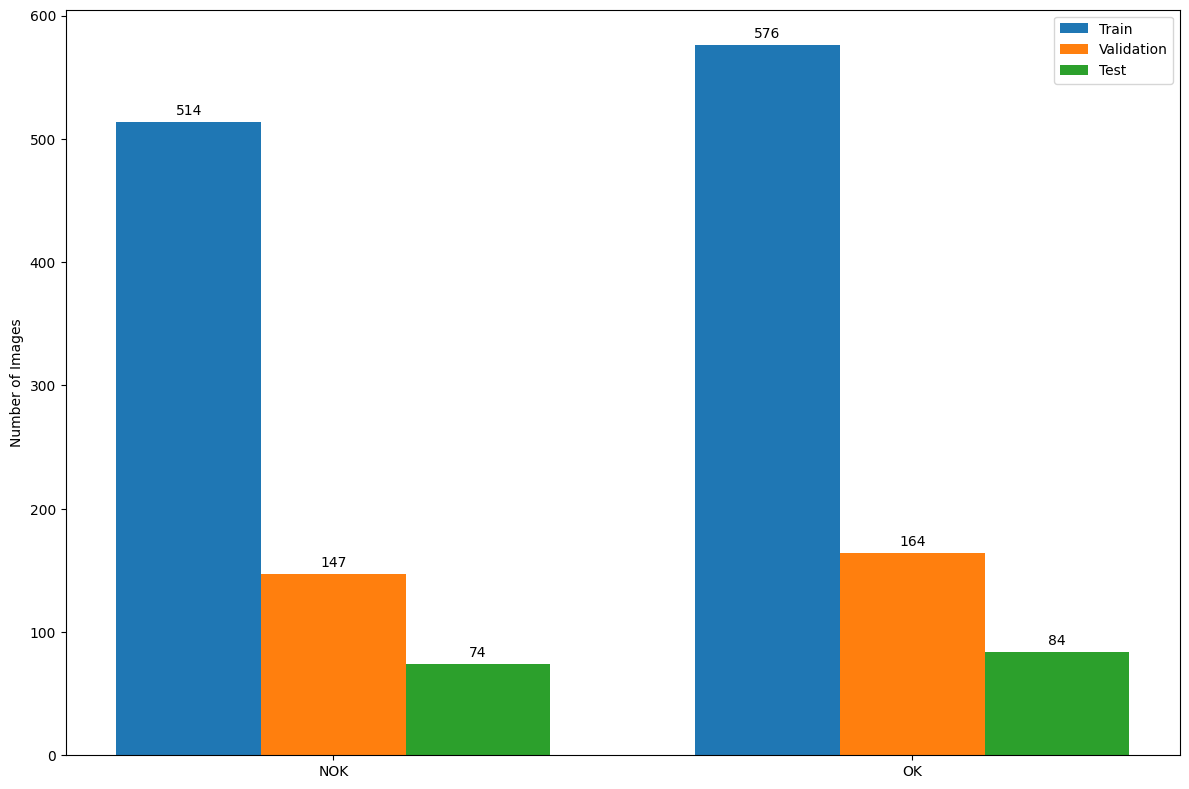

In [4]:
visualize_data(train_dir, val_dir, test_dir)

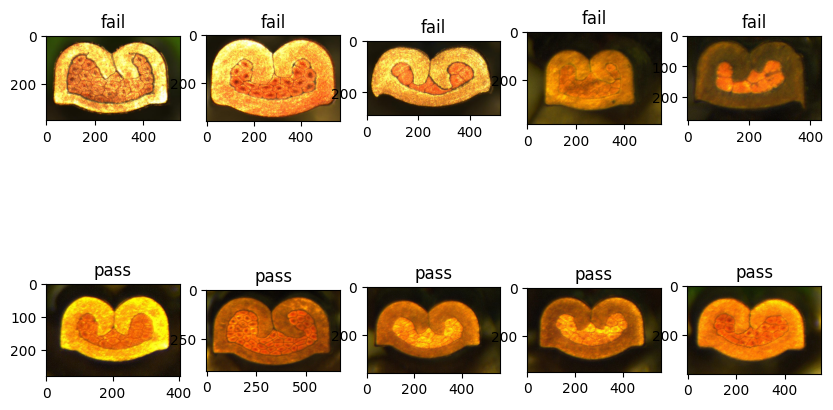

In [5]:
# Define the paths to the train directories for the "fail" and "pass" classes
fail_train_dir = os.path.join(data_dir, "train", "NOK")
pass_train_dir = os.path.join(data_dir, "train", "OK")

# Define the paths to a few images from each class
fail_images = [os.path.join(fail_train_dir, f) for f in os.listdir(fail_train_dir)[:5]]
pass_images = [os.path.join(pass_train_dir, f) for f in os.listdir(pass_train_dir)[:5]]

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))

for i, image_path in enumerate(fail_images):
    ax = axes[0, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("fail")

for i, image_path in enumerate(pass_images):
    ax = axes[1, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("pass")

plt.show()

In [9]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
    rotation_range=20,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
    )

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 1090 images belonging to 2 classes.


In [10]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 311 images belonging to 2 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    shuffle = False,
    seed=42
    )

Found 158 images belonging to 2 classes.


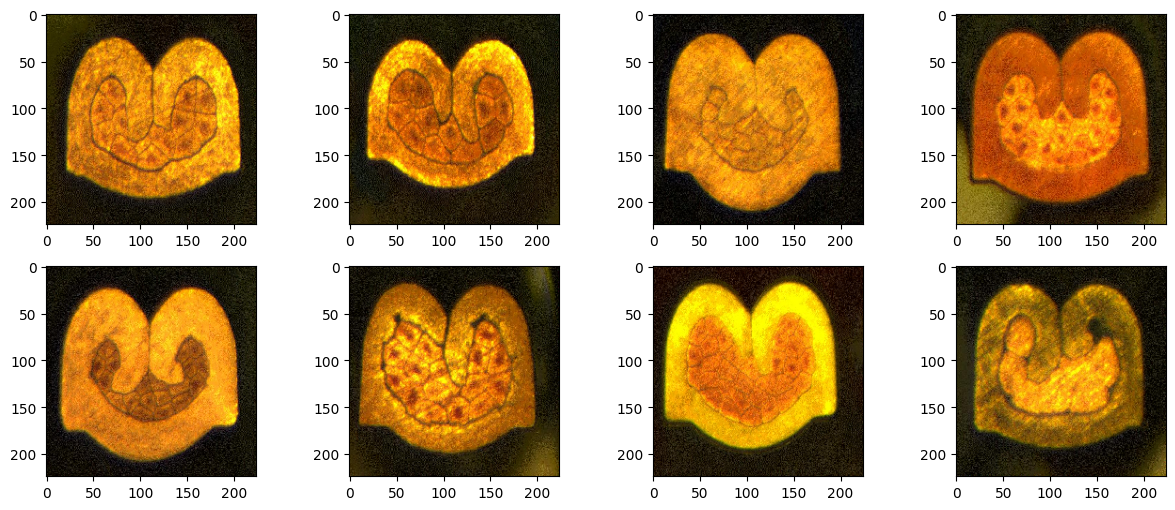

In [12]:
# Get a batch of images from the generator
img_batch, _ = train_data.next()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_batch[i])
    ax.axis('on')
    
plt.show()

In [13]:
class_names = train_data.class_indices
class_names

{'NOK': 0, 'OK': 1}

In [14]:
# Get the class labels from the data generator
labels = train_data.classes

# Calculate the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=labels)

# Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

In [15]:
class_weight_dict

{0: 1.0603112840466926, 1: 0.9461805555555556}

In [16]:
base_model = ResNet101V2(
        weights='imagenet', # Load pre-trained weights from the ImageNet dataset
        include_top=False, # Set to False to exclude the top fully connected layers from the model
        input_shape=(img_width, img_height, 3) # The input shape of the images
    )

gmp = GlobalAveragePooling2D()(base_model.output)

output = Dense(1, activation='sigmoid')(gmp)

model = Model(base_model.input, outputs=output)

In [17]:
for layer in base_model.layers:
    layer.trainable = False

In [18]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x0000018819059B70>,input_1,False
1,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x0000018817795A50>,conv1_pad,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x0000018817794760>,conv1_conv,False
3,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x0000018817903B50>,pool1_pad,False
4,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000018817795D80>,pool1_pool,False
...,...,...,...
374,<keras.layers.merging.add.Add object at 0x000001888C6C64D0>,conv5_block3_out,False
375,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001888C6C6050>,post_bn,False
376,<keras.layers.core.activation.Activation object at 0x000001888C5B90F0>,post_relu,False
377,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000001881907D510>,global_average_pooling2d,True


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [20]:
recall = Recall()
precision = Precision()

In [21]:
#optimizer = SGD(learning_rate=0.01, decay=0.01, momentum=0.9)
optimizer = Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [22]:
early_stopping_cb = EarlyStopping(patience=3,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [23]:
EPOCHS = 10

num_workers = multiprocessing.cpu_count()
#workers=num_workers,
#use_multiprocessing=True,
#class_weight=class_weight_dict
history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb],
                      class_weight=class_weight_dict
                  )

Epoch 1/10
136/136 [==============================] - 13s 57ms/step - loss: 0.6280 - accuracy: 0.7588 - recall: 0.7741 - precision: 0.7700 - val_loss: 0.3353 - val_accuracy: 0.8421 - val_recall: 0.8944 - val_precision: 0.8229
Epoch 2/10
136/136 [==============================] - 6s 46ms/step - loss: 0.3214 - accuracy: 0.8688 - recall: 0.8674 - precision: 0.8828 - val_loss: 0.4054 - val_accuracy: 0.8421 - val_recall: 0.9444 - val_precision: 0.7969
Epoch 3/10
136/136 [==============================] - 6s 48ms/step - loss: 0.2478 - accuracy: 0.8983 - recall: 0.9113 - precision: 0.8988 - val_loss: 0.2469 - val_accuracy: 0.9145 - val_recall: 0.9625 - val_precision: 0.8851
Epoch 4/10
136/136 [==============================] - 6s 46ms/step - loss: 0.2024 - accuracy: 0.9196 - recall: 0.9248 - precision: 0.9232 - val_loss: 0.2696 - val_accuracy: 0.9013 - val_recall: 0.9937 - val_precision: 0.8457
Epoch 5/10
136/136 [==============================] - 7s 48ms/step - loss: 0.1131 - accuracy: 0.966

In [24]:
len(base_model.layers)

377

In [25]:
base_model.trainable = True
for layer in base_model.layers:
  layer.trainable = False

In [26]:
for layer in base_model.layers:
  layer.trainable = True

In [27]:
#optimizer = SGD(learning_rate=0.001, decay=0.01, momentum=0.9)
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [28]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 
df 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x0000018819059B70>,input_1,True
1,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x0000018817795A50>,conv1_pad,True
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x0000018817794760>,conv1_conv,True
3,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x0000018817903B50>,pool1_pad,True
4,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000018817795D80>,pool1_pool,True
...,...,...,...
374,<keras.layers.merging.add.Add object at 0x000001888C6C64D0>,conv5_block3_out,True
375,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001888C6C6050>,post_bn,True
376,<keras.layers.core.activation.Activation object at 0x000001888C5B90F0>,post_relu,True
377,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000001881907D510>,global_average_pooling2d,True


In [29]:
df['Layer Trainable'].value_counts()[True]

379

In [30]:
early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [31]:
checkpoint_cb = ModelCheckpoint('model.h5',
                                save_best_only=True,
                                monitor='val_loss',
                                mode='min')

In [32]:
csv_logger = CSVLogger('training_log.csv')

In [33]:
EPOCHS = 100

num_workers = multiprocessing.cpu_count()

history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb,checkpoint_cb, csv_logger],
                      class_weight=class_weight_dict
                   )

Epoch 1/100
136/136 [==============================] - 26s 153ms/step - loss: 1.2755 - accuracy: 0.5157 - recall: 0.5068 - precision: 0.6807 - val_loss: 17.6416 - val_accuracy: 0.4836 - val_recall: 0.1063 - val_precision: 0.5484
Epoch 2/100
136/136 [==============================] - 18s 133ms/step - loss: 0.7536 - accuracy: 0.5157 - recall: 0.1867 - precision: 0.6485 - val_loss: 42.4393 - val_accuracy: 0.4638 - val_recall: 0.0123 - val_precision: 0.5000
Epoch 3/100
136/136 [==============================] - 18s 133ms/step - loss: 0.7290 - accuracy: 0.4945 - recall: 0.1643 - precision: 0.5767 - val_loss: 4227.2617 - val_accuracy: 0.4704 - val_recall: 0.0062 - val_precision: 1.0000
Epoch 4/100
136/136 [==============================] - 20s 145ms/step - loss: 0.6981 - accuracy: 0.5231 - recall: 0.2059 - precision: 0.6592 - val_loss: 1.0627 - val_accuracy: 0.4836 - val_recall: 0.0692 - val_precision: 0.5500
Epoch 5/100
136/136 [==============================] - 19s 143ms/step - loss: 0.686

In [34]:
def visualize_training_results(results):
    history = results.history
    
    # Find the epoch where validation accuracy was highest
    best_epoch = np.argmin(history['val_loss'])
    
    for m in ['loss', 'accuracy', 'precision', 'recall']:
        plt.figure(figsize=(15,5))
        plt.plot(history[m], label='Training', marker='o', color='blue')
        plt.plot(history[f'val_{m}'], label='Validation', marker='o', color='red')
        plt.axvline(x=best_epoch, linestyle='--', color='green', label='Best epoch')
        plt.xlabel('Epochs')
        plt.legend()
        plt.title(m.title())
    
    plt.show()

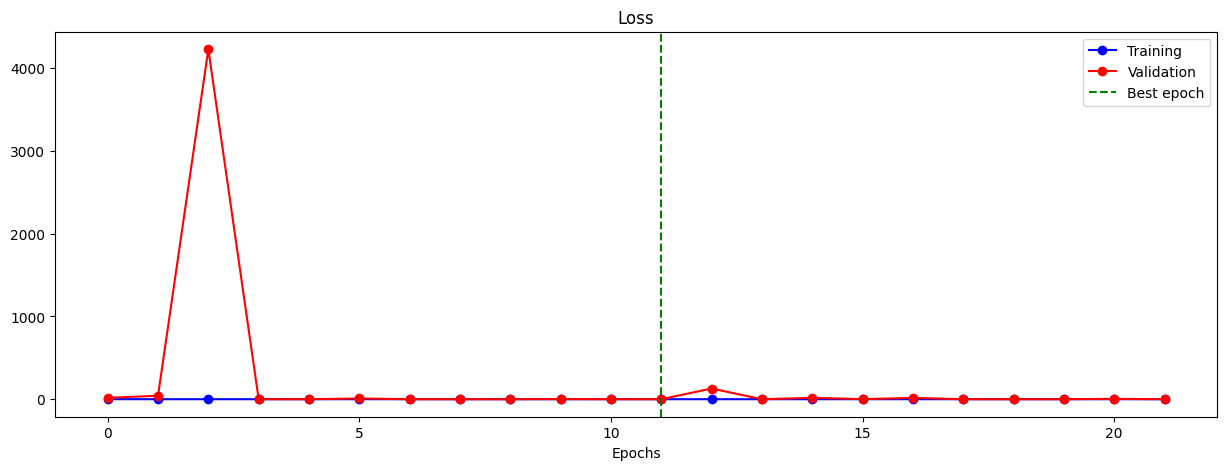

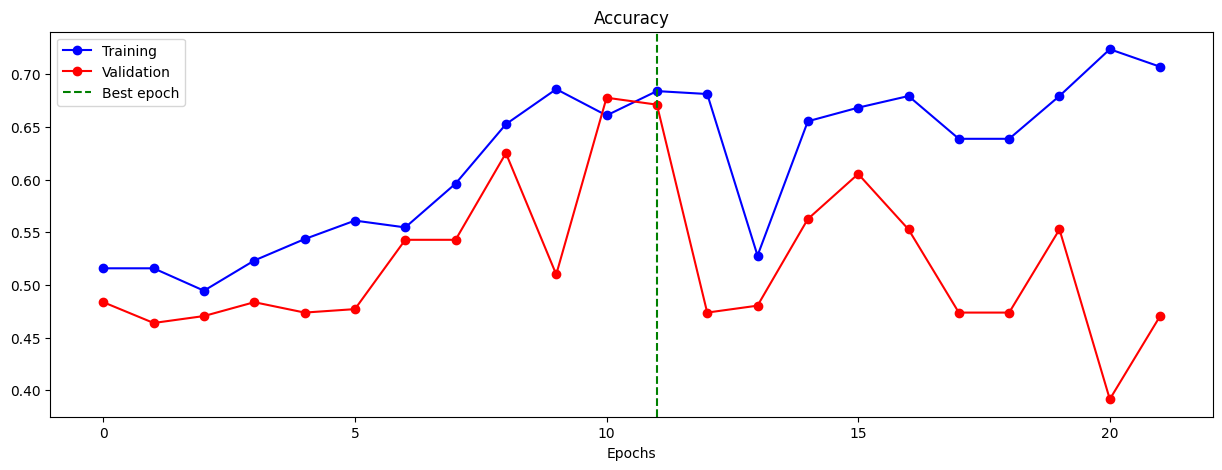

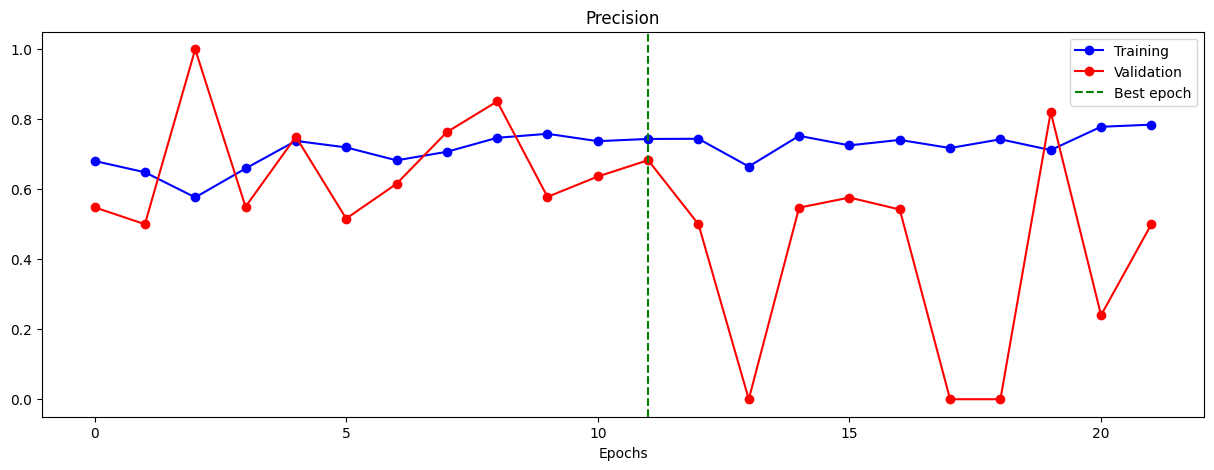

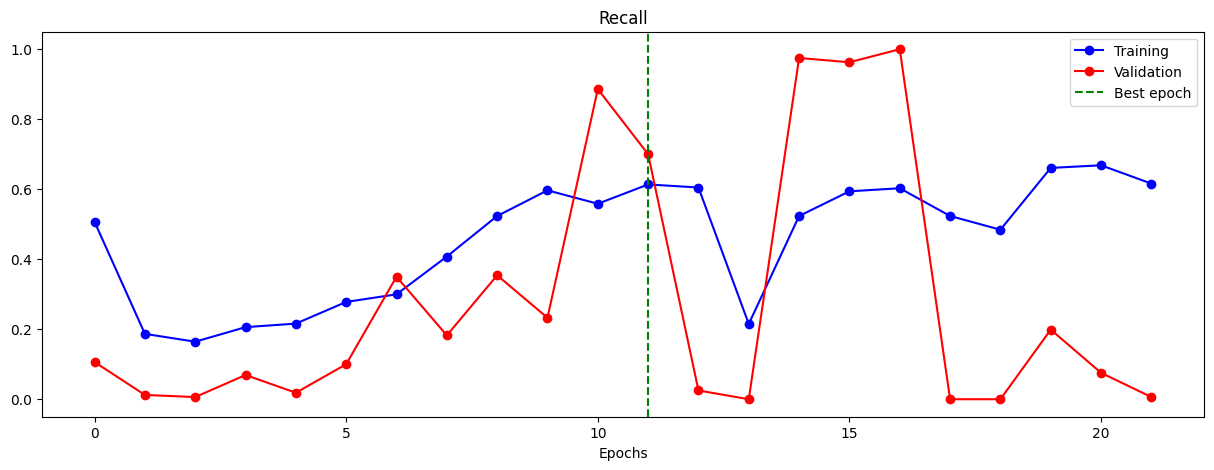

In [35]:
visualize_training_results(history)

In [36]:
def plot_metrics(model, test_data):
    # Get the predicted labels and true labels
    y_pred = model.predict(test_data)
    y_pred = y_pred > 0.5
    y_true = test_data.labels

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax1)
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix')
    ax1.xaxis.set_ticklabels(['NO OK', 'OK'])
    ax1.yaxis.set_ticklabels(['NO OK', 'OK'])

    # Calculate the true positive rate (TPR) and false positive rate (FPR) at different thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    ax2.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
  
    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('True Positive Rate (TPR)')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")

    plt.show()
    
    # Generate the classification report
    report = classification_report(y_true, y_pred)
    # Print the report
    print(report)


20/20 [==============================] - 2s 57ms/step


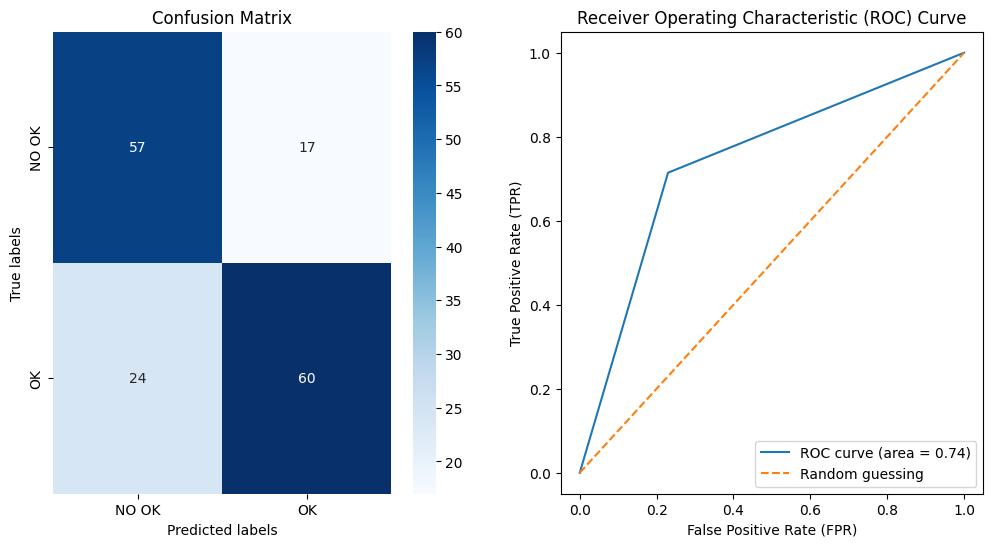

              precision    recall  f1-score   support

           0       0.70      0.77      0.74        74
           1       0.78      0.71      0.75        84

    accuracy                           0.74       158
   macro avg       0.74      0.74      0.74       158
weighted avg       0.74      0.74      0.74       158



In [37]:
plot_metrics(model, test_data)